***ELIE*** ***GHAZZOUL***

# Importing the packages




In [ ]:
!pip install pmdarima
!pip install fastai

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import yfinance as yf
from fastai.tabular.all import add_datepart
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from pmdarima.arima import auto_arima
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM



#Loading the dataset

In [ ]:
# Define the ticker symbol and time period
ticker_symbol = "AAPL"
start_date = "2013-01-01"
end_date = "2018-12-31"

# Download historical data from Yahoo Finance
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Save the data to a CSV file for future use
data.to_csv("apple_stock_data.csv")


[*********************100%%**********************]  1 of 1 completed


In [ ]:
data = pd.read_csv("apple_stock_data.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1509 non-null   object 
 1   Open       1509 non-null   float64
 2   High       1509 non-null   float64
 3   Low        1509 non-null   float64
 4   Close      1509 non-null   float64
 5   Adj Close  1509 non-null   float64
 6   Volume     1509 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 82.6+ KB


Date should have Dtype: datetime not object

In [ ]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
#checking if it worked
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1509 non-null   datetime64[ns]
 1   Open       1509 non-null   float64       
 2   High       1509 non-null   float64       
 3   Low        1509 non-null   float64       
 4   Close      1509 non-null   float64       
 5   Adj Close  1509 non-null   float64       
 6   Volume     1509 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 82.6 KB


In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.747728,560518000
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.536329,352965200
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.075720,594333600
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,15.981151,484156400
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.024168,458707200


# Plotting my time series

Text(0.5, 1.0, 'AAPL graph')

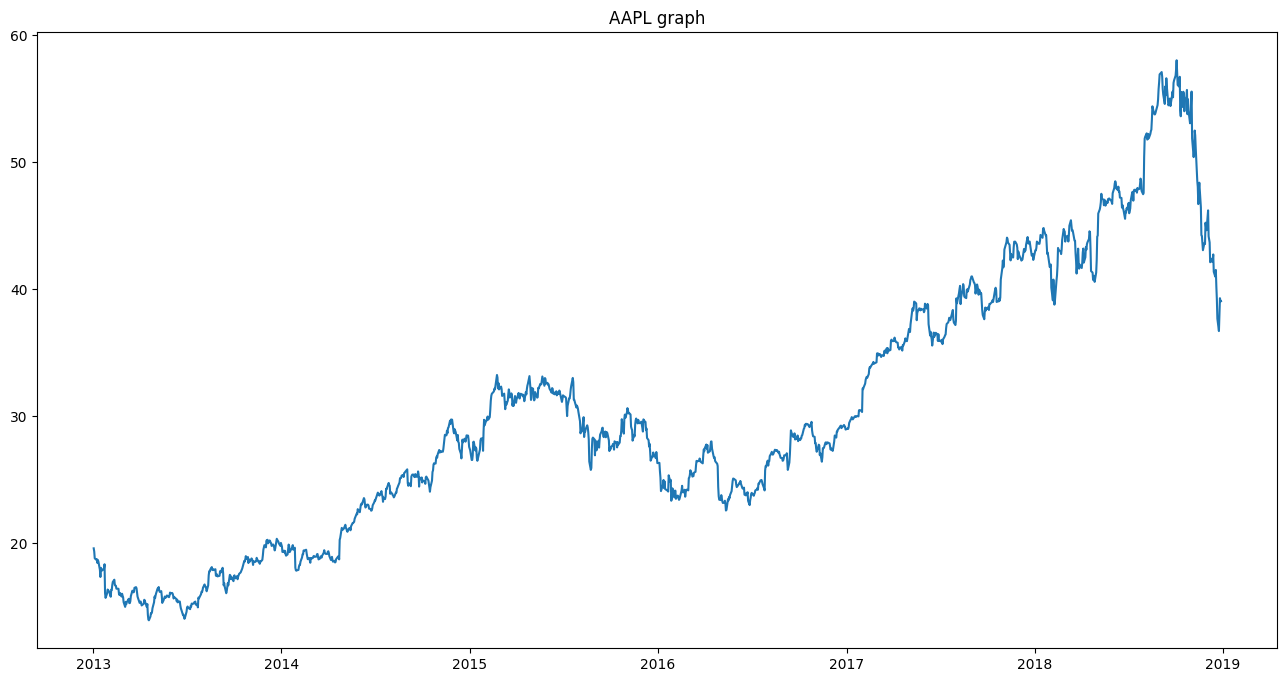

In [ ]:
#setting index as date
data.index = data['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(data['Close'], label='Close Price history')
plt.title('AAPL graph')

In [ ]:
#setting index as date values
data['Date'] = pd.to_datetime(data.Date,format='%Y-%m-%d')
data.index = data['Date']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2013-01-02 to 2018-12-28
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1509 non-null   datetime64[ns]
 1   Open       1509 non-null   float64       
 2   High       1509 non-null   float64       
 3   Low        1509 non-null   float64       
 4   Close      1509 non-null   float64       
 5   Adj Close  1509 non-null   float64       
 6   Volume     1509 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 94.3 KB


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2013-01-02 to 2018-12-28
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1509 non-null   datetime64[ns]
 1   Open       1509 non-null   float64       
 2   High       1509 non-null   float64       
 3   Low        1509 non-null   float64       
 4   Close      1509 non-null   float64       
 5   Adj Close  1509 non-null   float64       
 6   Volume     1509 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 94.3 KB


#Creating a new dataset, containing the needed columns

I only need the date and  the stock price (target variable), so I am going to create a new dataframe containg only these two

In [ ]:
#creating dataframe with date and the target variable
data = data.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(data)),columns=['Date', 'Close'])

for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

In [ ]:
new_data.head()

,Date,Close
0,2013-01-02 00:00:00,19.608213
1,2013-01-03 00:00:00,19.360714
2,2013-01-04 00:00:00,18.821428
3,2013-01-07 00:00:00,18.710714
4,2013-01-08 00:00:00,18.76107


#Splitting the dataset into train and test

 While splitting the data into train and validation set, we cannot use random splitting since that will destroy the time component. So here we have set the last year’s data into validation and the 4 years’ data before that into train set.

In [ ]:
# splitting into train and validation
train = new_data[:1206]
valid = new_data[1206:]

In [ ]:
#shape of training set
print('Shape of the training set')
print(train.shape)

#shape of validation set
print('Shape of the valid set')
print(valid.shape)


Shape of the training set
(1206, 2)
Shape of the valid set
(303, 2)


# MODELS

## Moving Average model

In [ ]:
# Generate predictions for the training set
train_preds = []
for i in range(0, train.shape[0]):
    a = train['Close'][len(train)-303+i:].sum() + sum(train_preds)
    b = a / 303
    train_preds.append(b)

# Store the predictive values in the train dataframe
# Store the predictive values in the train dataframe using .loc
train.loc[:, 'Predictions'] = train_preds


# Calculate RMSE for the training set
train_rmse = np.sqrt(np.mean(np.power((train['Close'] - train_preds), 2)))
print('\nRMSE value on training set:')
print(train_rmse)

# Generate predictions for the validation set
valid_preds = []
for i in range(0, valid.shape[0]):
    a = train['Close'][len(train)-303+i:].sum() + sum(valid_preds)
    b = a / 303
    valid_preds.append(b)

# Store the predictive values in the valid dataframe
valid.loc[:, 'Predictions'] = valid_preds

# Calculate RMSE for the validation set
valid_rmse = np.sqrt(np.mean(np.power((valid['Close'] - valid_preds), 2)))
print('\nRMSE value on validation set:')
print(valid_rmse)



RMSE value on training set:
225.97114967006482

RMSE value on validation set:
11.727854076068352


In [ ]:
print(train['Close'].mean())
print(valid['Close'].mean())

26.054634841520397
46.42844071089238


 The high RMSE on the training dataset(more than 8 times the mean),indicates that my model has a poor performance. Despite its lower RMSE on the test set, that could be because our test set is relatively small, it's a bad model.

we're going to plot it to visualize the result

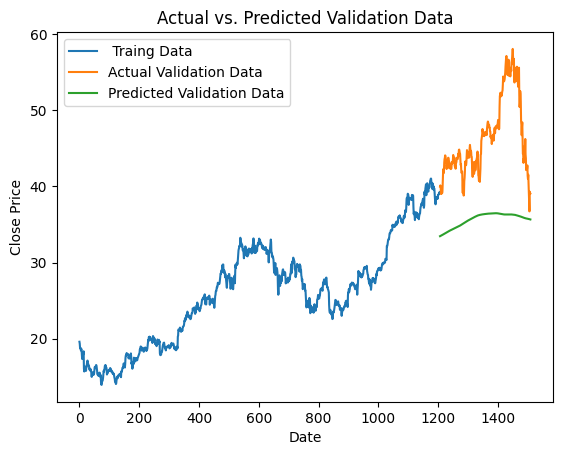

In [ ]:
# Plot the training and validation data along with predictions
plt.plot(train['Close'], label=' Traing Data')
plt.plot(valid['Close'], label='Actual Validation Data')
plt.plot(valid['Predictions'], label='Predicted Validation Data')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Validation Data')
plt.legend()

# Show plot
plt.show()

Poor performance, as expected

##Linear Regression


for our next model, we will use the linear regression

### Feature engineering

In [ ]:
new_data1=new_data.copy()

#create features
add_datepart(new_data1, 'Date')
new_data1.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


In [ ]:
new_data1.head()

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,19.608213,2013,1,1,2,2,2,False,False,False,False,False,False
1,19.360714,2013,1,1,3,3,3,False,False,False,False,False,False
2,18.821428,2013,1,1,4,4,4,False,False,False,False,False,False
3,18.710714,2013,1,2,7,0,7,False,False,False,False,False,False
4,18.76107,2013,1,2,8,1,8,False,False,False,False,False,False


my hypothesis is that the first and last days of the week could potentially affect the closing price of the stock far more than the other days. So I have created a feature that identifies whether a given day is Monday/Friday or Tuesday/Wednesday/Thursday.

In [ ]:
new_data1['mon_fri'] = 0
for i in range(len(new_data1)):
    if new_data1['Dayofweek'].iloc[i] == 0 or new_data1['Dayofweek'].iloc[i] == 4:
        new_data1.loc[i, 'mon_fri'] = 1
    else:
        new_data1.loc[i, 'mon_fri'] = 0


In [ ]:
new_data1.head()

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,mon_fri
0,19.608213,2013,1,1,2,2,2,False,False,False,False,False,False,0
1,19.360714,2013,1,1,3,3,3,False,False,False,False,False,False,0
2,18.821428,2013,1,1,4,4,4,False,False,False,False,False,False,1
3,18.710714,2013,1,2,7,0,7,False,False,False,False,False,False,1
4,18.76107,2013,1,2,8,1,8,False,False,False,False,False,False,0


In [ ]:
#split into train and validation
train = new_data1[:1206]
valid = new_data1[1206:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [ ]:
# Predict on training set
train_predictions = model.predict(x_train)
# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
print("RMSE on training set:", train_rmse)

# Predict on test set
test_predictions = model.predict(x_valid)

# Store the predictive values in the valid dataframe
valid.loc[:, 'Predictions'] = preds

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(y_valid, test_predictions))
print("RMSE on test set:", test_rmse)

RMSE on training set: 3.2240702587742143
RMSE on test set: 8.333344515274565


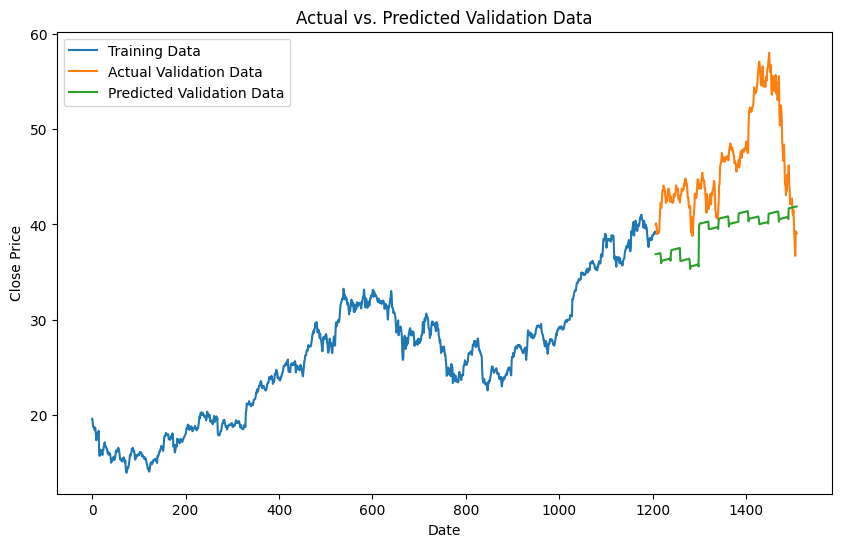

In [ ]:

# Plot the training data, actual validation data, and predicted validation data
plt.figure(figsize=(10, 6))
plt.plot(train['Close'], label='Training Data')
plt.plot(valid['Close'], label='Actual Validation Data')
plt.plot(valid['Predictions'], label='Predicted Validation Data')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Validation Data')
plt.legend()

# Show the plot
plt.show()


It's better than the moving average model , but it's not quite accurate

##KNN model


In [ ]:
#normalizing my features
scaler = MinMaxScaler(feature_range=(0, 1))
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)


In [ ]:
#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
# Predict on training set
train_predictions = model.predict(x_train)

#predicting the test set
preds = model.predict(x_valid)



In [ ]:
# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
print("RMSE on training set:", train_rmse)

#rmse on the test
rmse=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print("RMSE on training set:", rmse)

RMSE on training set: 1.6647127547820053
RMSE on training set: 15.452655357764467


This model is clearly overfitting the dataset.

Visualizing it

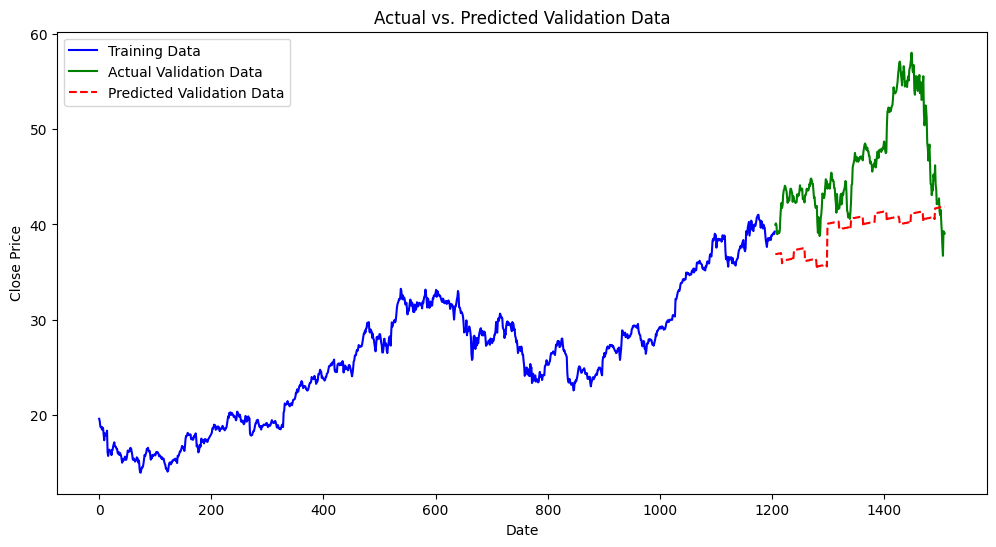

In [ ]:
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the training data
plt.plot(train['Close'], color='blue', label='Training Data')

# Plot the validation data and predictions
plt.plot(valid['Close'], color='green', label='Actual Validation Data')
plt.plot(valid['Predictions'], color='red', linestyle='--', label='Predicted Validation Data')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Validation Data')

# Add legend
plt.legend()

# Show the plot
plt.show()


not a good model

#LTSM model


In [ ]:
#creating dataframe
data = data.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(data)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:1206,:]
valid = dataset[1206:,:]

In [ ]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(74,len(train)):
    x_train.append(scaled_data[i-74:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 303 values, using past 74 from the train data
inputs = new_data[len(new_data) - len(valid) - 74:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(74,inputs.shape[0]):
    X_test.append(inputs[i-74:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

1132/1132 - 57s - loss: 0.0014 - 57s/epoch - 51ms/step
10/10 [==============================] - 1s 31ms/step


In [ ]:
rmse=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rmse

2.2529864880831276

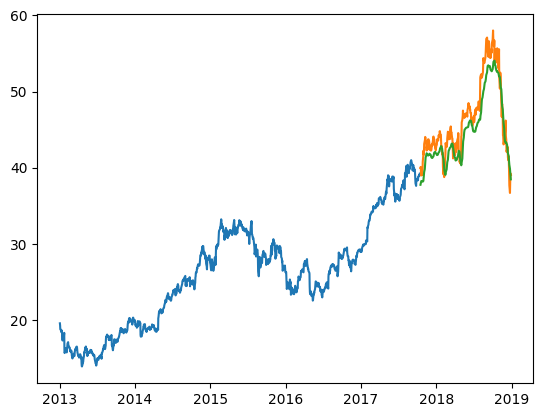

In [ ]:
#for plotting
train = new_data[:1206]
#valid = new_data[1206:]
valid = new_data[1206:].copy()
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

This code can be applied to all the stocks, I provided the models only on the apple stock.

# ***ALBERTO***

In [ ]:
#necessary installation
!pip install ta
!pip install mplfinance

[*********************100%%**********************]  1 of 1 completed


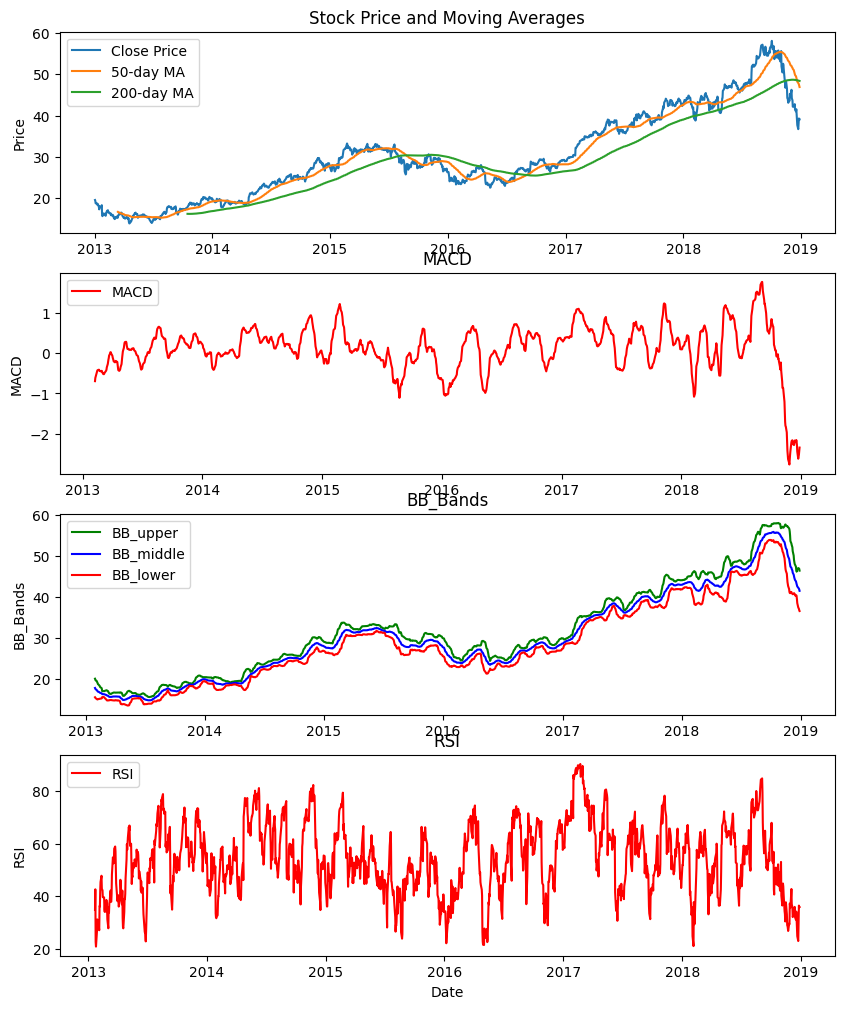

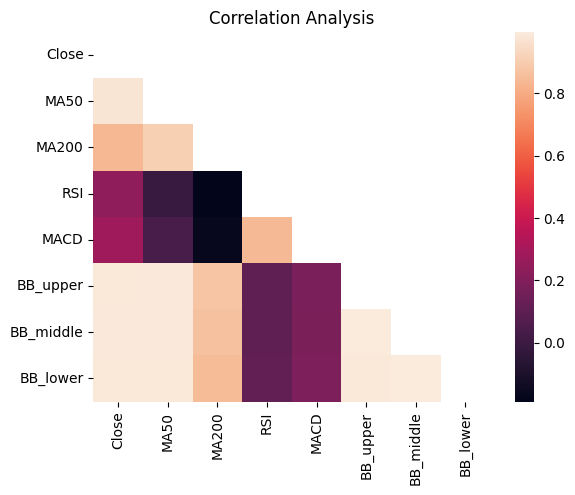

RMSE on test set: 1.384313304286365
Coefficient of Determination (R²): 0.9249574394852185


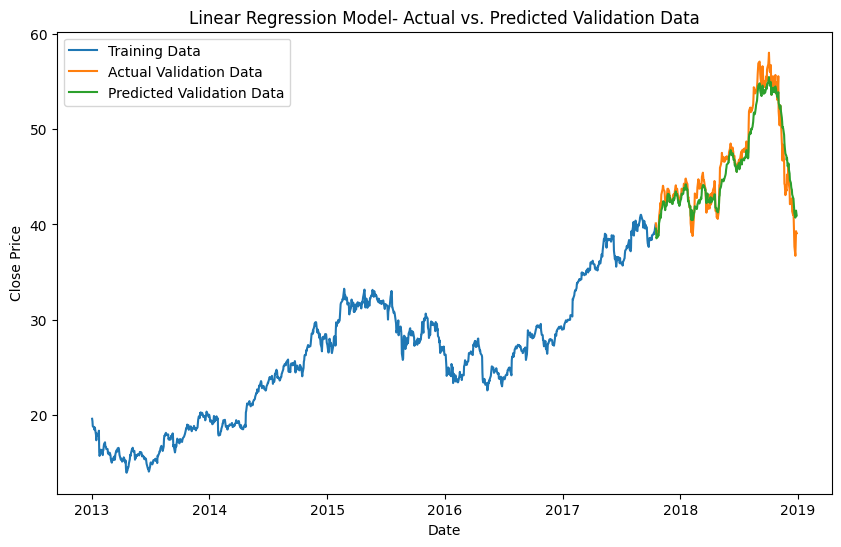

Epoch 1/25
72/72 [==============================] - 8s 65ms/step - loss: 0.0055
Epoch 2/25
72/72 [==============================] - 3s 48ms/step - loss: 4.6074e-04
Epoch 3/25
72/72 [==============================] - 3s 48ms/step - loss: 4.2745e-04
Epoch 4/25
72/72 [==============================] - 4s 58ms/step - loss: 3.9575e-04
Epoch 5/25
72/72 [==============================] - 4s 52ms/step - loss: 3.6288e-04
Epoch 6/25
72/72 [==============================] - 3s 48ms/step - loss: 3.4578e-04
Epoch 7/25
72/72 [==============================] - 3s 47ms/step - loss: 3.1143e-04
Epoch 8/25
72/72 [==============================] - 5s 64ms/step - loss: 3.0641e-04
Epoch 9/25
72/72 [==============================] - 3s 48ms/step - loss: 2.8533e-04
Epoch 10/25
72/72 [==============================] - 4s 49ms/step - loss: 2.8444e-04
Epoch 11/25
72/72 [==============================] - 4s 58ms/step - loss: 2.7275e-04
Epoch 12/25
72/72 [==============================] - 4s 54ms/step - loss: 2.80

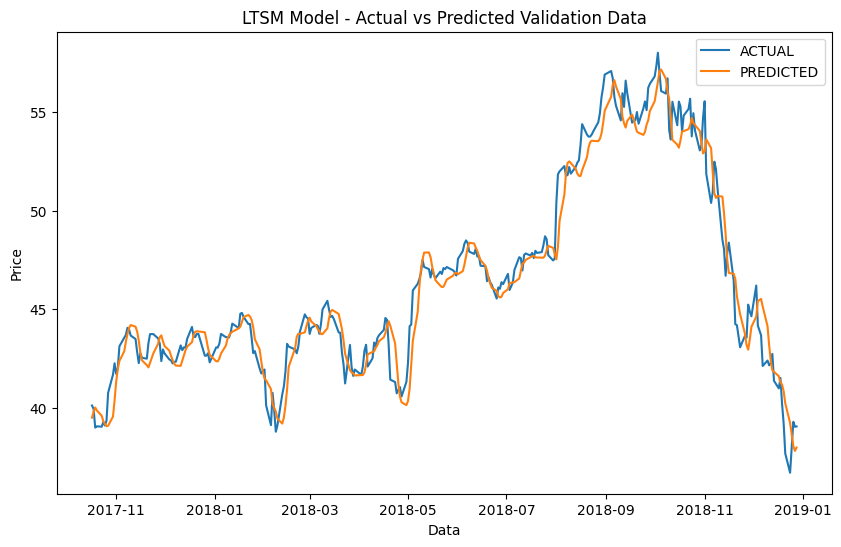

Mean Squared Error (MSE): 1.1604612535455523
Coefficient of Determination (R²): 0.9545567375117057


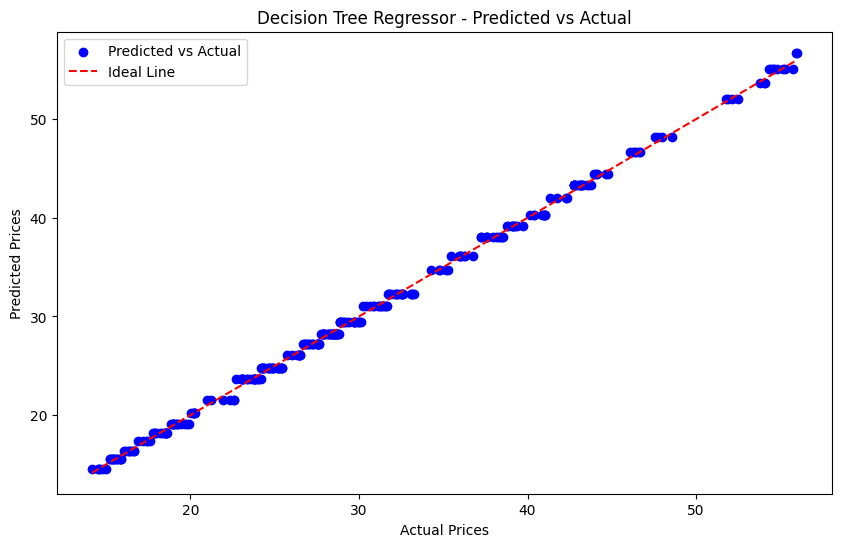

Mean Squared Error (MSE): 0.15740173433293334
Coefficient of Determination (R²): 0.9985400672529351


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


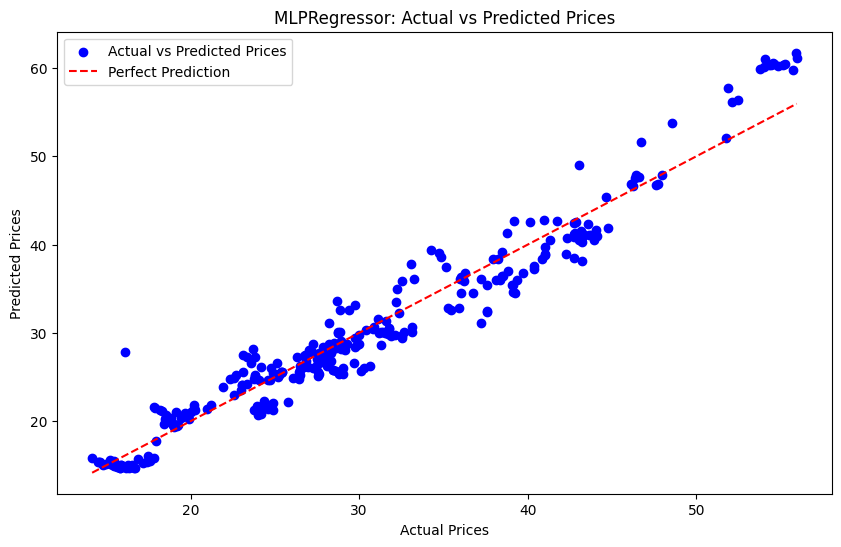

Mean Squared Error (MSE): 6.601034097647345
Coefficient of Determination (R²): 0.9387740809560383


In [ ]:
#import library
import yfinance as yf
import numpy as np
import pandas as pd
import ta
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras import models
from keras  import layers
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor

# Download the data
#stocks = ['AAPL', 'AMZN', 'GOOGL', 'INTC', 'META', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'TSLA']
stock = yf.download("AAPL", start='2013-01-01', end='2018-12-31')

# Creating a copy of the DataFrame
data = stock.copy()

#Transform the Date column used as Index in a normal colum
data.reset_index(inplace=True)

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

#create a dataframe with Date and the target variable ("Close")
new_data1 = pd.DataFrame(index=range(0,len(data)),columns=['Date', 'Close'])
new_data1['Date'] = data['Date']
new_data1['Close'] = data['Close']

##FEATURES ENGIGNEERING

#MOVING AVERAGE 50/200
new_data1['MA50'] = ta.trend.sma_indicator(close = new_data1['Close'], window=50)
new_data1['MA200'] = ta.trend.sma_indicator(close = new_data1['Close'], window=200)

# RSI (Relative Strength Index)
new_data1['RSI'] = ta.momentum.rsi(close=new_data1['Close'], window=14)

# MACD (Moving Average Convergence Divergence)
new_data1['MACD'] = ta.trend.macd(close=new_data1['Close'], window_slow=26, window_fast=12)

# Bollinger Bands
new_data1['BB_upper'] = ta.volatility.bollinger_hband(close=new_data1['Close'], window=20)
new_data1['BB_middle'] = ta.volatility.bollinger_mavg(close=new_data1['Close'], window=20)
new_data1['BB_lower'] = ta.volatility.bollinger_lband(close=new_data1['Close'], window=20)


##VISUALIZATION

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

# MOVING AVERAGES
ax1.plot(new_data1['Date'], new_data1['Close'], label='Close Price')
ax1.plot(new_data1['Date'], new_data1['MA50'], label='50-day MA')
ax1.plot(new_data1['Date'], new_data1['MA200'], label='200-day MA')
ax1.set_ylabel('Price')
ax1.set_title('Stock Price and Moving Averages')
ax1.legend()

#MACD
ax2.plot(new_data1['Date'], new_data1["MACD"], color='red', label='MACD')
ax2.set_ylabel('MACD')
ax2.set_title('MACD')
ax2.legend()


# BB BANDS
ax3.plot(new_data1['Date'], new_data1["BB_upper"], color='green', label='BB_upper')
ax3.plot(new_data1['Date'], new_data1["BB_middle"], color='blue', label='BB_middle')
ax3.plot(new_data1['Date'], new_data1["BB_lower"], color='red', label='BB_lower')
ax3.set_ylabel('BB_Bands')
ax3.set_title('BB_Bands')
ax3.legend()

# RSI
ax4.plot(new_data1['Date'], new_data1["RSI"], color='red', label='RSI')
ax4.set_ylabel('RSI')
ax4.set_title('RSI')
ax4.legend()

plt.xlabel('Date')
plt.show()

#NEW_DATASET
new_data1.set_index(new_data1["Date"], inplace=True)

# Split the data in Train and Valid
train, valid = train_test_split( new_data1, test_size=0.2, shuffle=False, random_state=42)

numerical_col = train.select_dtypes(include=['float64', 'int64'])

# Compute the CORRELATION MATRIX
numerical_col = train.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_col.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create the heatmap
plt.figure(dpi=100)
sns.heatmap(corr_matrix, annot=False, mask=mask, lw=0, linecolor='white', fmt="0.2f")
plt.title('Correlation Analysis')
plt.axis('tight')
plt.show()


##LINEAR REGRESSION MODEL

#OPTIMIZATION FOR LINEAR REGRESSION MODEL
x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

x = [x_train, x_valid ]

x_train.fillna(x_train.mean(), inplace=True)
x_train["Date"] = x_train['Date'].astype('int64') / 10**9
x_valid["Date"] = x_valid['Date'].astype('int64') / 10**9

y_train = y_train.to_frame()
y_train.reset_index(inplace=True)
y_valid = y_valid.to_frame()
y_valid.reset_index(inplace=True)
del y_valid["Date"]
del y_train["Date"]

#implement linear regression
model = LinearRegression()
model.fit(x_train,y_train)

#Predict on training set
train_predictions = model.predict(x_train)

# Predict on test set
test_predictions = model.predict(x_valid)

# Store the predictive values in the valid dataframe
valid.loc[:, 'Predictions'] = test_predictions

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(y_valid, test_predictions))
r2 = r2_score(y_valid, test_predictions)
print("RMSE on test set:", test_rmse)
print(f"Coefficient of Determination (R²): {r2}")

# Plot the training data, actual validation data, and predicted validation data
plt.figure(figsize=(10, 6))
plt.plot(train['Close'], label='Training Data')
plt.plot(valid['Close'], label='Actual Validation Data')
plt.plot(valid['Predictions'], label='Predicted Validation Data')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression Model- Actual vs. Predicted Validation Data')
plt.legend()
plt.show()

##LONG SHORT-TERM MEMORY MODEL

# OPTIMIZATION for LONG SHORT-TERM MEMORY MODEL
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

train_data = scaled_data[0:int(len(scaled_data)*0.8), :]
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# implement LONG SHORT-TERM MEMORY MODEL

model = models.Sequential()
model.add(layers.LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(units=50))
model.add(layers.Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=16)
test_data = scaled_data[int(len(scaled_data)*0.8) - 60:, :]
x_test, y_test = [], data['Close'][int(len(scaled_data)*0.8):]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
mse = np.mean(np.power(y_test - predicted_prices.flatten(), 2))
mae = np.mean(np.abs(y_test - predicted_prices.flatten()))

valid['Predictions'] = predicted_prices

#Evaluation
mse = mean_squared_error(y_test, predicted_prices)
r2 = r2_score(y_test, predicted_prices)

#Plot
plt.figure(figsize=(10, 6))
plt.plot(valid[['Close','Predictions']], label=["ACTUAL", 'PREDICTED'])
plt.xlabel('Data')
plt.ylabel('Price')
plt.title('LTSM Model - Actual vs Predicted Validation Data')
plt.legend()
plt.show()

print(f"Mean Squared Error (MSE): {mse}")
print(f"Coefficient of Determination (R²): {r2}")

#OPTIMIZATION FOR Decision Tree Regressor model

features = ["Close", "MA50",	"MA200",	"RSI",	"MACD",	"BB_upper",	"BB_middle",	"BB_lower"]
dtr_data = pd.DataFrame()
for i in features:
  dtr_data.add(new_data1[i])
  dtr_data[i] = new_data1[i].values
dtr_data.fillna(dtr_data.mean(), inplace=True)

# TARGET definition
target = dtr_data['Close']

# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(dtr_data, target, test_size=0.2, random_state=42)

# Application of the Decision Tree Regressor model
model = DecisionTreeRegressor(random_state=42, max_depth= 20, min_samples_leaf=10, min_samples_split=20, max_leaf_nodes=30)
# tuning the parameter to obtain different results
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Ideal Line')
plt.title('Decision Tree Regressor - Predicted vs Actual')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()


print(f"Mean Squared Error (MSE): {mse}")
print(f"Coefficient of Determination (R²): {r2}")



##MPL REGRESSOR MODEL
#OPTIMIZATION FOR MPL REGRESSOR MODEL

mpl_data = dtr_data.copy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(mpl_data)

# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

# Application of the MLPRegressor model
model = MLPRegressor(hidden_layer_sizes=(16,8), activation='relu', solver='adam', alpha=0.01, random_state=42)
#modify the hidden_layer_size values to obtain a less/more precise model
model.fit(X_train, y_train)

# Valutazione del modello
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Prediction')
plt.title('MLPRegressor: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()

print(f"Mean Squared Error (MSE): {mse}")
print(f"Coefficient of Determination (R²): {r2}")


# ***ROBERT***

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


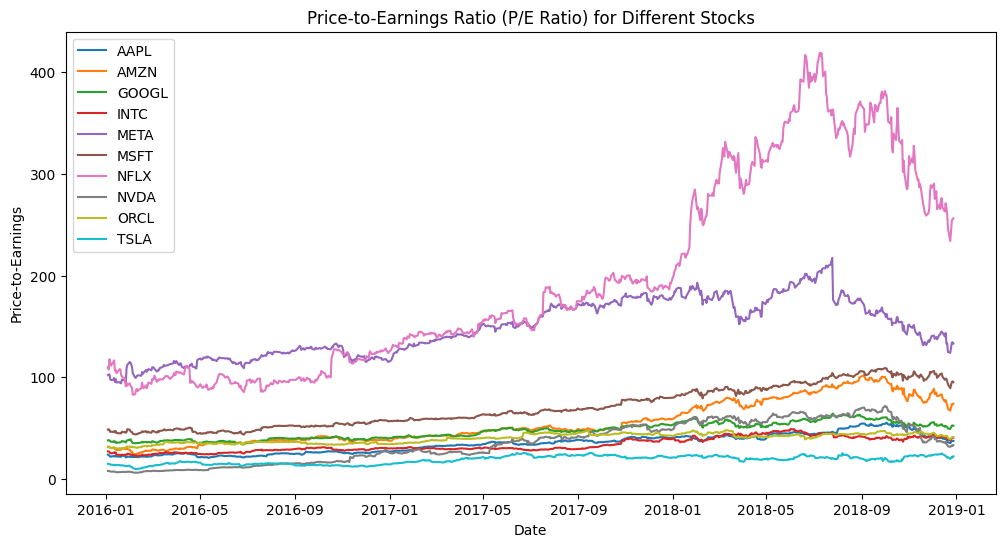

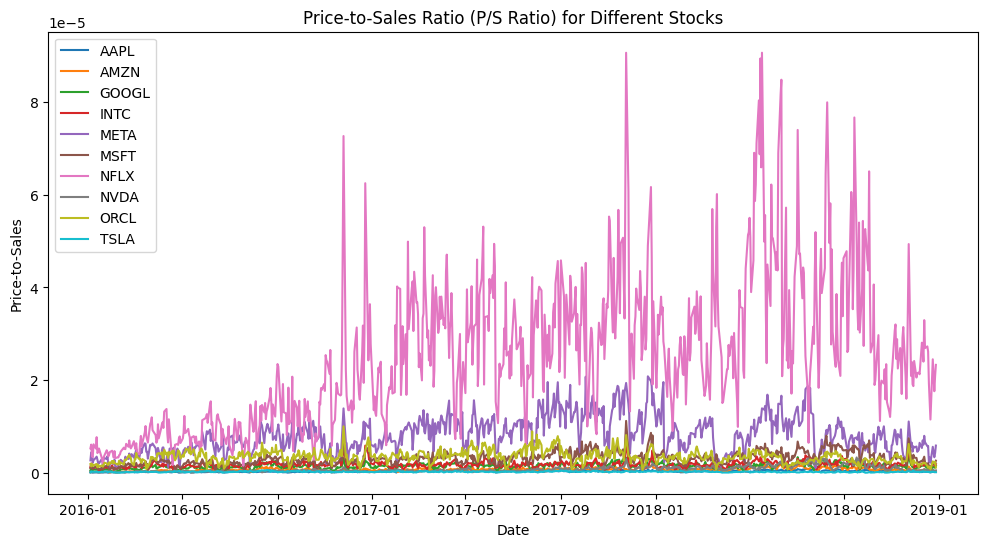

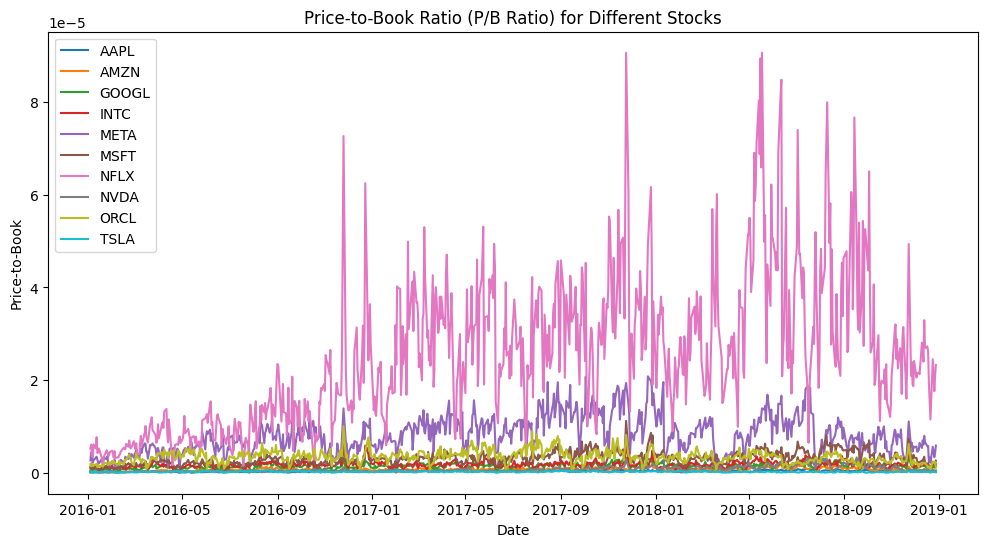

Mean Squared Error (MSE): 1.1000169020088492e-28
R-squared (R2): 1.0
Mean Absolute Error (MAE): 8.540629572215774e-15
Median Absolute Error (MedAE): 7.105427357601002e-15
Adjusted R-squared: 1.0


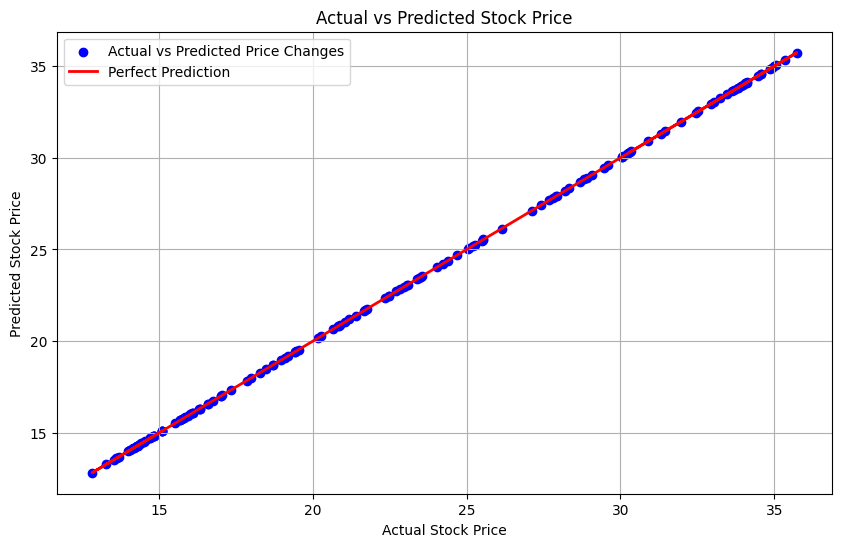

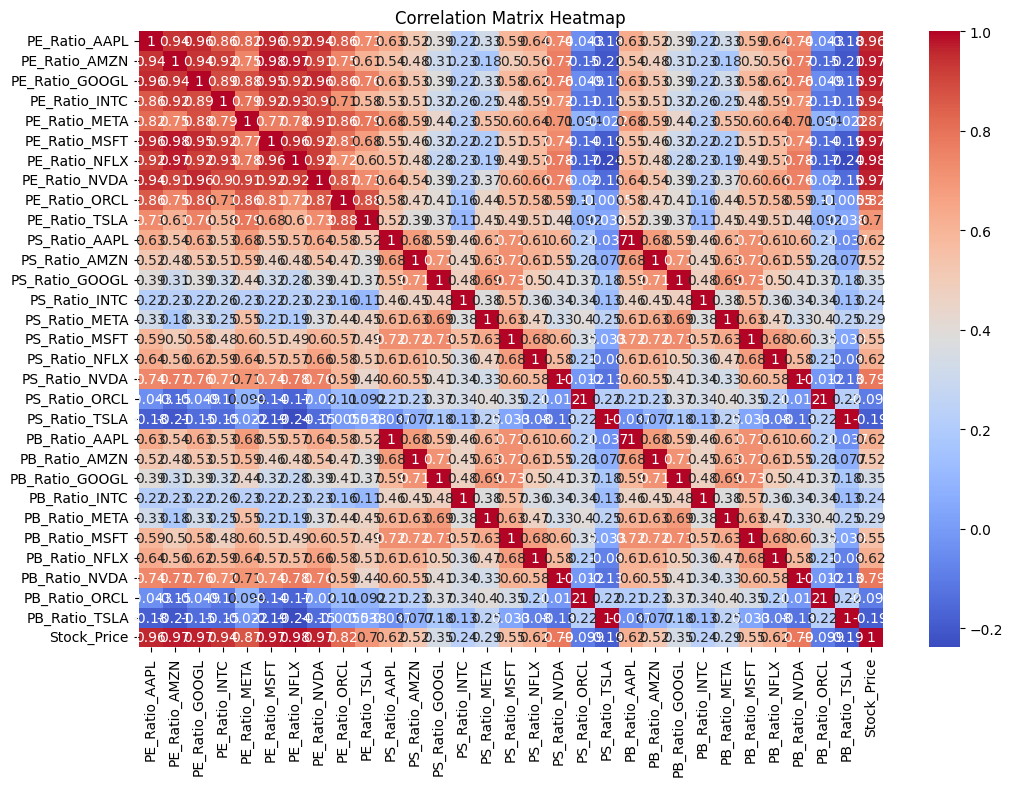

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


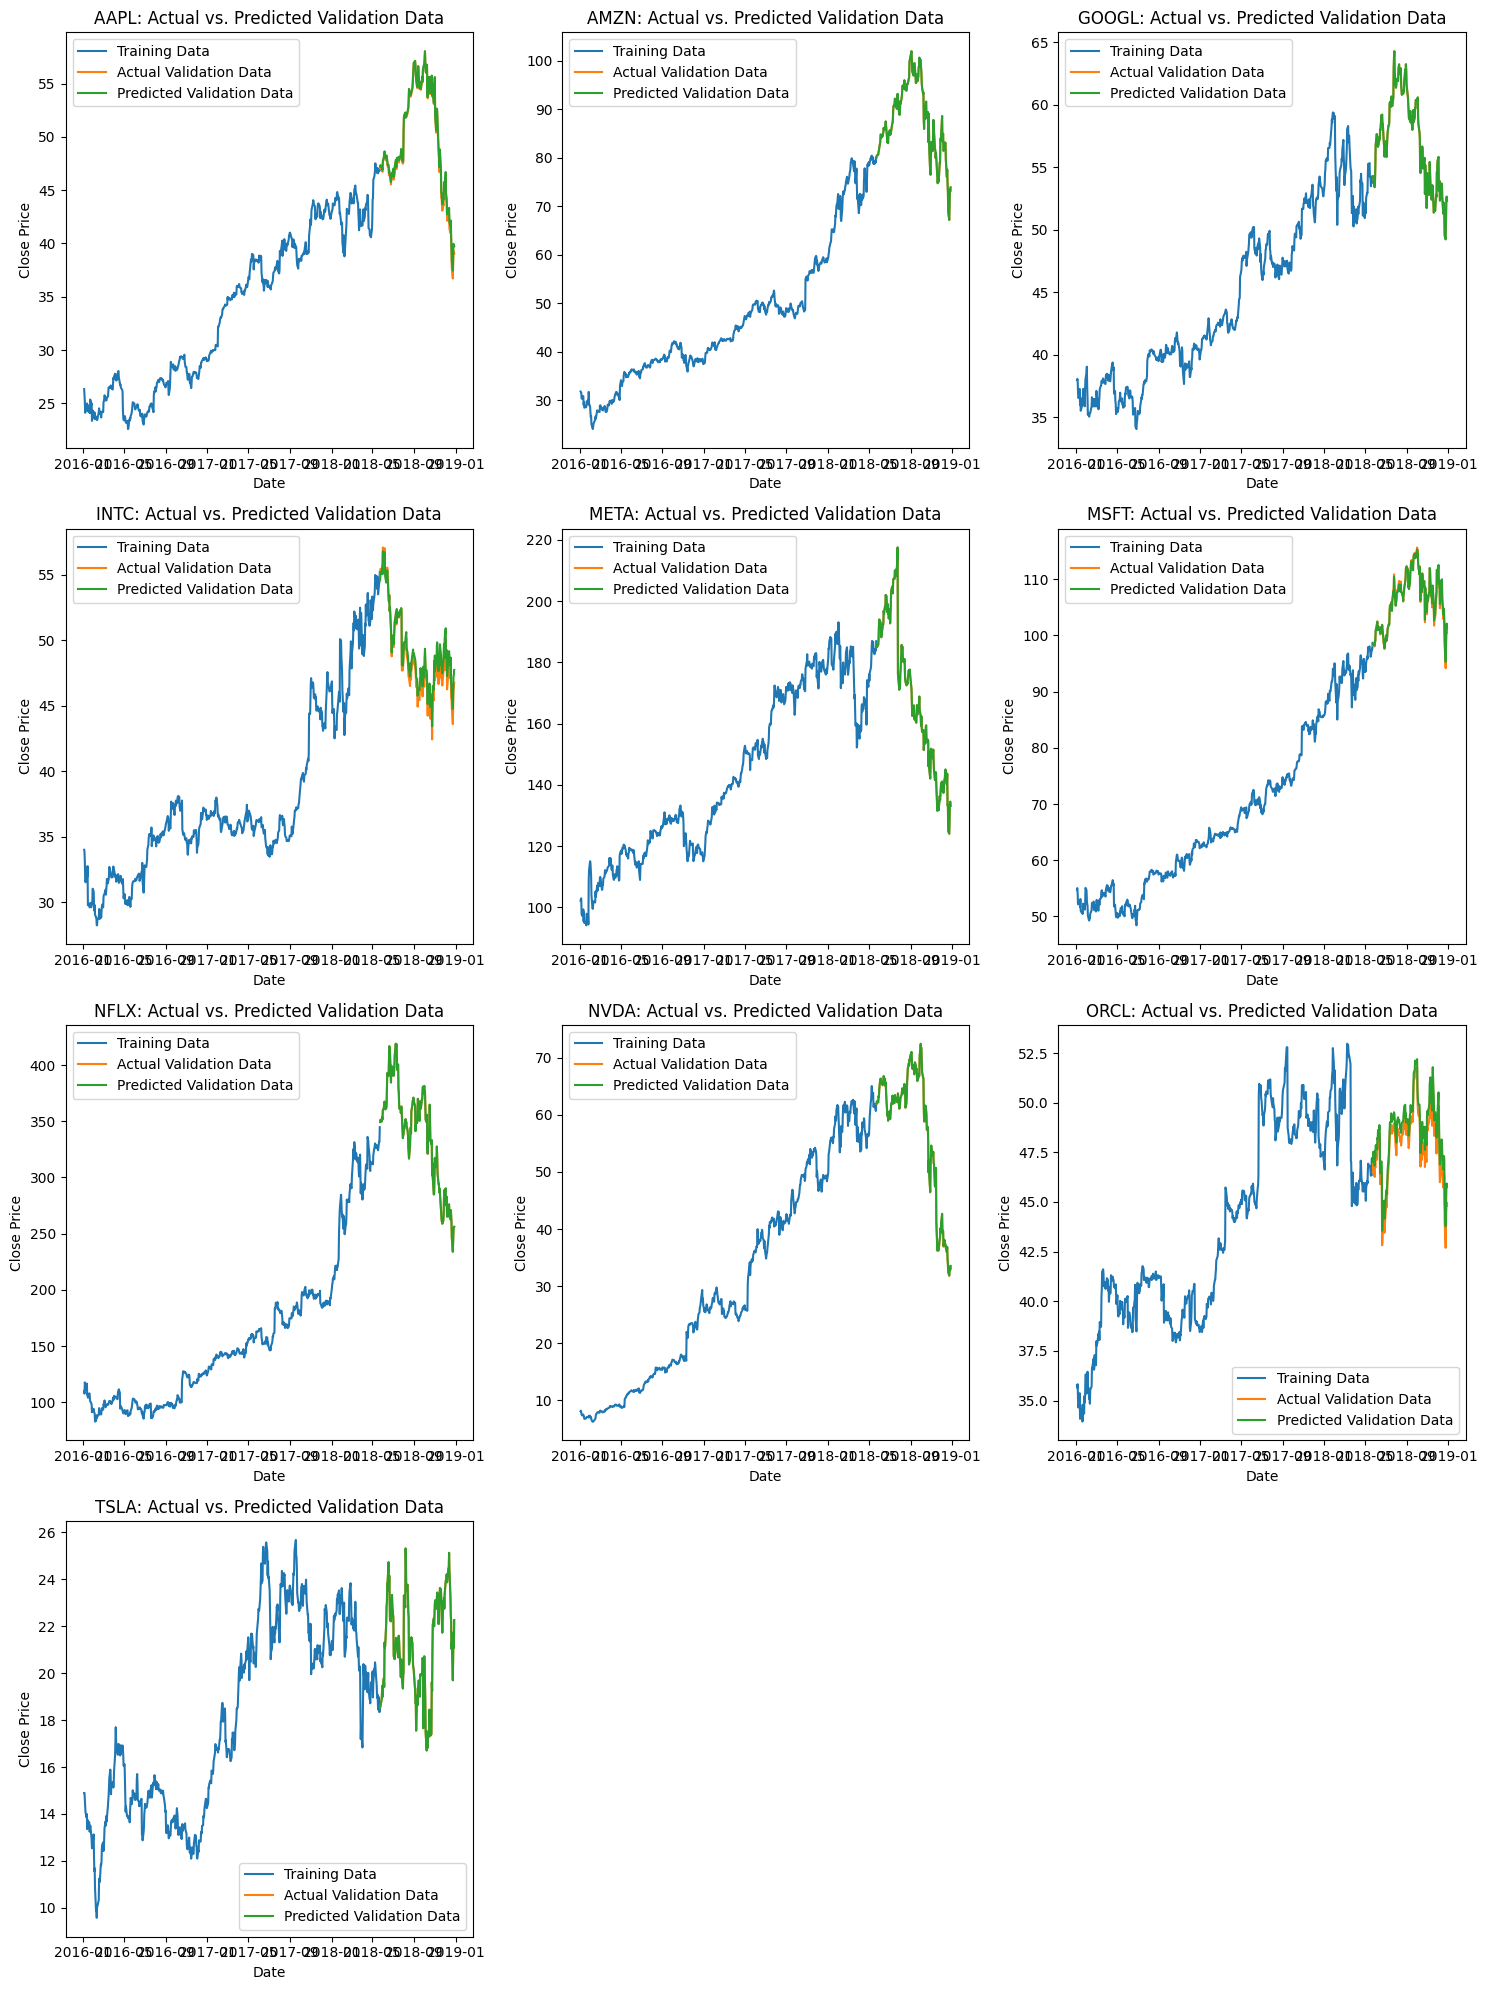

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define stocks and time period
stocks = ["AAPL", "AMZN", "GOOGL", "INTC", "META", "MSFT", "NFLX", "NVDA", "ORCL", "TSLA"]
start_date = "2016-01-01"
end_date = "2018-12-31"

# Calculate financial ratios
pe_ratios = pd.DataFrame()
ps_ratios = pd.DataFrame()
pb_ratios = pd.DataFrame()

for stock in stocks:
    stock_data = yf.download(stock, start=start_date, end=end_date)

    eps = stock_data['Close'] / stock_data['Adj Close']
    pe_ratio = stock_data['Close'] / eps
    pe_ratios[stock] = pe_ratio

    ps_ratio = stock_data['Close'] / stock_data['Volume']
    ps_ratios[stock] = ps_ratio

    book_value_per_share = stock_data['Open'] * stock_data['Volume'] / stock_data['Open']
    pb_ratio_approx = stock_data['Close'] / book_value_per_share
    pb_ratios[stock] = pb_ratio_approx

# Plot financial ratios
def plot_ratios(data, title):
    plt.figure(figsize=(12, 6))
    for stock in data.columns:
        plt.plot(data.index, data[stock], label=stock)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(title.split()[0])
    plt.legend()
    plt.show()

plot_ratios(pe_ratios, 'Price-to-Earnings Ratio (P/E Ratio) for Different Stocks')
plot_ratios(ps_ratios, 'Price-to-Sales Ratio (P/S Ratio) for Different Stocks')
plot_ratios(pb_ratios, 'Price-to-Book Ratio (P/B Ratio) for Different Stocks')

# Merge dataframes and calculate average stock price
merged_df = pd.concat([pe_ratios, ps_ratios, pb_ratios], axis=1).dropna()
merged_df.columns = ["PE_Ratio_" + stock for stock in stocks] + ["PS_Ratio_" + stock for stock in stocks] + ["PB_Ratio_" + stock for stock in stocks]
merged_df['Stock_Price'] = merged_df.mean(axis=1)

# Train-test split
X_columns = ["PE_Ratio_" + stock for stock in stocks] + ["PS_Ratio_" + stock for stock in stocks] + ["PB_Ratio_" + stock for stock in stocks]
X = merged_df[X_columns]
y = merged_df['Stock_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))
medae = np.median(np.abs(y_test - y_pred))
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)
print("Median Absolute Error (MedAE):", medae)
print("Adjusted R-squared:", adj_r2)

# Plot actual vs predicted stock prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted Price Changes')
plt.plot(y_test, y_test, color='red', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Stock Price')
plt.ylabel('Predicted Stock Price')
plt.title('Actual vs Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot correlation matrix
correlation_matrix = merged_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap")
plt.show()

# Plot actual vs predicted stock prices for individual stocks
num_cols = 3
num_rows = (len(stocks) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
axes = axes.flatten()

for i, stock in enumerate(stocks):
    data = yf.download(stock, start=start_date, end=end_date)

    eps = data['Close'] / data['Adj Close']
    pe_ratio = data['Close'] / eps

    ps_ratio = data['Close'] / data['Volume']

    book_value_per_share = data['Open'] * data['Volume'] / data['Open']

    pb_ratio_approx = data['Close'] / book_value_per_share

    data['PE_Ratio'] = pe_ratio
    data['PS_Ratio'] = ps_ratio
    data['PB_Ratio'] = pb_ratio_approx

    data['Date'] = pd.to_datetime(data.index)
    data.set_index('Date', inplace=True)

    train_size = int(0.8 * len(data))
    train = data.iloc[:train_size]
    valid = data.iloc[train_size:]

    features = ['PE_Ratio', 'PS_Ratio', 'PB_Ratio']
    target = 'Close'

    x_train = train[features]
    y_train = train[target]
    x_valid = valid[features]
    y_valid = valid[target]

    model = LinearRegression()
    model.fit(x_train, y_train)

    train_predictions = model.predict(x_train)

    valid_predictions = model.predict(x_valid)

    ax = axes[i]
    ax.plot(train.index, train['Close'], label='Training Data')
    ax.plot(valid.index, valid['Close'], label='Actual Validation Data')
    ax.plot(valid.index, valid_predictions, label='Predicted Validation Data')
    ax.set_title(f'{stock}: Actual vs. Predicted Validation Data')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.legend()

for i in range(len(stocks), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()